# Expected SARSA and $n$-step bootstrapping

In this notebook, you will implement expected SARSA and $n$-step bookstrapping described in Chapters 6 and 7 of [Sutton and Barto's book, Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html).  

### Install dependencies

In [1]:
! pip install numpy pandas

### Imports

In [2]:
import numpy as np
import random
import sys          # We use sys to get the max value of a float
import pandas as pd # We only use pandas for displaying tables nicely
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.3f}'.format

### ```World``` class and globals

The ```World``` is a grid represented as a two-dimensional array of characters where each character can represent free space, an obstacle, or a terminal. Each non-obstacle cell is associated with a reward that an agent gets for moving to that cell (can be 0). The size of the world is _width_ $\times$ _height_ characters.

A _state_ is a tuple $(x,y)$.

An empty world is created in the ```__init__``` method. Obstacles, rewards and terminals can then be added with ```add_obstacle``` and ```add_reward```.

To calculate the next state of an agent (that is, an agent is in some state $s = (x,y)$ and performs and action, $a$), ```get_next_state()```should be called.

In [3]:
# Globals:
ACTIONS = ("up", "down", "left", "right")

# Rewards, terminals and obstacles are characters:
REWARDS = {" ": 0, ".": 0.1, "+": 10, "-": -10}
TERMINALS = ("+", "-") # Note a terminal should also have a reward assigned
OBSTACLES = ("#")

# Discount factor
gamma = 1

# The probability of a random move:
rand_move_probability = 0

class World:
  def __init__(self, width, height):
    self.width = width
    self.height = height
    # Create an empty world where the agent can move to all cells
    self.grid = np.full((width, height), ' ', dtype='U1')

  def add_obstacle(self, start_x, start_y, end_x=None, end_y=None):
    """
    Create an obstacle in either a single cell or rectangle.
    """
    if end_x == None: end_x = start_x
    if end_y == None: end_y = start_y

    self.grid[start_x:end_x + 1, start_y:end_y + 1] = OBSTACLES[0]

  def add_reward(self, x, y, reward):
    assert reward in REWARDS, f"{reward} not in {REWARDS}"
    self.grid[x, y] = reward

  def add_terminal(self, x, y, terminal):
    assert terminal in TERMINALS, f"{terminal} not in {TERMINALS}"
    self.grid[x, y] = terminal

  def is_obstacle(self, x, y):
    if x < 0 or x >= self.width or y < 0 or y >= self.height:
      return True
    else:
      return self.grid[x ,y] in OBSTACLES

  def is_terminal(self, x, y):
    return self.grid[x ,y] in TERMINALS

  def get_reward(self, x, y):
    """
    Return the reward associated with a given location
    """
    return REWARDS[self.grid[x, y]]

  def get_next_state(self, current_state, action):
    """
    Get the next state given a current state and an action. The outcome can be
    stochastic  where rand_move_probability determines the probability of
    ignoring the action and performing a random move.
    """
    assert action in ACTIONS, f"Unknown acion {action} must be one of {ACTIONS}"

    x, y = current_state

    # If our current state is a terminal, there is no next state
    if self.grid[x, y] in TERMINALS:
      return None

    # Check of a random action should be performed:
    if np.random.rand() < rand_move_probability:
      action = np.random.choice(ACTIONS)

    if action == "up":      y -= 1
    elif action == "down":  y += 1
    elif action == "left":  x -= 1
    elif action == "right": x += 1

    # If the next state is an obstacle, stay in the current state
    return (x, y) if not self.is_obstacle(x, y) else current_state


## A simple world

We will create a simple $8\times8$ world, where the agent should start in the top-left corner at $(0,0)$ and find its way to the bottom-right corner at $(7,7)$.

In [4]:
world = World(8, 8)
world.add_terminal(7, 7, "+")

print(world.grid.T)
display(pd.DataFrame(world.grid.T))

[[' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' '+']]


,0,1,2,3,4,5,6,7
0,,,,,,,,
1,,,,,,,,
2,,,,,,,,
3,,,,,,,,
4,,,,,,,,
5,,,,,,,,
6,,,,,,,,
7,,,,,,,,+


## Exercise: Expected SARSA

Implement and test expected SARSA, see page 133 of [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html). The implementation of expected SARSA is very similar to regular SARSA, so you can use your SARSA implementation as a starting point for your expected SARSA implementation.

In [41]:
# TODO: Implement your code here -- you need a Q-table to keep track of action
#       value estimates and a policy-function that returns an epsilon greedy
#       policy based on your estimates.


epsilon = 0.1
alpha = 0.05
gamma = 0.9

def SARSA_policy(state, Q):
  actions = {a: epsilon/len(ACTIONS) for a in ACTIONS}
  actions[ACTIONS[np.argmax(Q[state])]] = 1-epsilon + epsilon/len(ACTIONS)
  return actions


def expected_sarsa(world, policy, start_state, EPISODES, alpha=1):
  avgSteps = []
  Q = np.random.rand(world.width, world.height,len(ACTIONS))
  for episode in range(EPISODES):
    steps = 0
    current_state = start_state
    possible_actions = policy(current_state, Q)
    current_action = random.choices(population=list(possible_actions.keys()),
                                    weights=possible_actions.values(), k=1)

    action_to_index = {action: i for i, action in enumerate(ACTIONS)}

    while not world.is_terminal(*current_state):
      # Get the next state from the world
      next_state = world.get_next_state(current_state, current_action[0])
      possible_actions = policy(next_state, Q)
      next_action = random.choices(population=list(possible_actions.keys()),
                                   weights=possible_actions.values(), k=1)

      # Calculate the expected value of the next state
      expected_value = 0
      for action in ACTIONS:
        action_prob = possible_actions[action] # Probability of taking 'action'
        action_index = action_to_index[action] # Index of 'action' in Q-table
        expected_value += action_prob * Q[next_state[0], next_state[1], action_index]

      Q[current_state[0], current_state[1], action_to_index[current_action[0]]] += alpha * (
          world.get_reward(*next_state) + gamma * expected_value
          - Q[current_state[0], current_state[1], action_to_index[current_action[0]]])
      current_state = next_state
      current_action = next_action
      steps += 1
    avgSteps.append(steps)


  return Q, avgSteps, steps

# def expected_sarsa(world, policy, start_state, EPISODES):
#   Q = np.random.rand(world.width, world.height,len(ACTIONS))
#   for episode in range(EPISODES):
#     current_state = start_state
#     possible_actions = policy(current_state, Q)
#     current_action = random.choices(population=list(possible_actions.keys()),
#                                     weights=possible_actions.values(), k=1)

#     action_to_index = {action: i for i, action in enumerate(ACTIONS)}

#     while not world.is_terminal(*current_state):
#       # Get the next state from the world
#       next_state = world.get_next_state(current_state, current_action[0])
#       possible_actions = policy(next_state, Q)
#       next_action = random.choices(population=list(possible_actions.keys()),
#                                    weights=possible_actions.values(), k=1)

#       # Calculate the expected value of the next state
#       expected_value = 0
#       for action in ACTIONS:
#         action_prob = possible_actions[action] # Probability of taking 'action'
#         action_index = action_to_index[action] # Index of 'action' in Q-table
#         expected_value += action_prob * Q[next_state[0], next_state[1], action_index]

#       Q[current_state[0], current_state[1], action_to_index[current_action[0]]] += alpha * (
#           world.get_reward(*next_state) + gamma * expected_value
#           - Q[current_state[0], current_state[1], action_to_index[current_action[0]]])
#       current_state = next_state
#       current_action = next_action

#   return Q




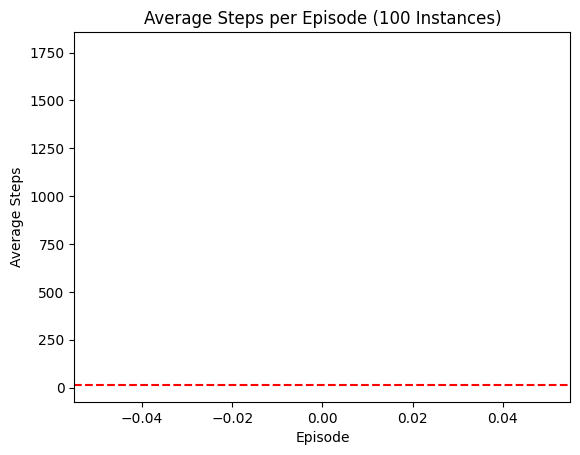

SARSA


,0,1,2,3,4,5,6,7
0,down,right,down,left,right,right,up,right
1,right,up,right,up,left,right,down,up
2,down,up,left,down,left,left,down,right
3,left,up,down,up,up,right,down,right
4,right,left,up,right,up,up,right,left
5,left,down,down,left,left,right,up,left
6,down,right,down,down,down,up,up,down
7,up,up,left,right,right,right,right,


[3789, 130, 41, 52, 60, 24, 33, 157, 60, 99]   99


In [40]:


def epsilon_greedy(state, Q):
  x,y = state
  if np.random.rand() <= epsilon:
    return random.choice(ACTIONS)
  else:
    return ACTIONS[np.argmax(Q[x,y])]


def sarsa(world, start_state, EPISODES, alpha):
  avgSteps = []
  Q = np.random.rand(world.width, world.height,len(ACTIONS)) # Arbitrær Q
  # Q = np.zeros((world.width, world.height,len(ACTIONS))) # Arbitrær Q
  # C = 5  # Konstant værdi for initialisering  
  # Q = np.full((world.width, world.height, len(ACTIONS)), C)


  for episode in range(EPISODES):
    steps = 0
    current_state = start_state
    current_action = epsilon_greedy(current_state, Q)

    action_to_index = {action: i for i, action in enumerate(ACTIONS)}

    while not world.is_terminal(current_state[0], current_state[1]):

      # Get the next state and action from the world
      next_state = world.get_next_state(current_state, current_action)
      next_action = epsilon_greedy(next_state, Q)

      # Update Q(st, at)
      Q[current_state[0], current_state[1], action_to_index[current_action]] += alpha * (
          world.get_reward(*next_state) + gamma *
          Q[next_state[0], next_state[1], action_to_index[next_action]] -
          Q[current_state[0], current_state[1], action_to_index[current_action]])
      current_state = next_state
      current_action = next_action
      steps += 1
    avgSteps.append(steps)

  return Q, avgSteps, steps

EPISODES = 1
INSTANCES = 10
alpha = 0.1
epsilon = 0.1
gamma = 0.9

world = World(8, 8)
world.add_terminal(7, 7, "+")

steps_all_instances = np.zeros(EPISODES)

for instance in range(INSTANCES):
    # print(f"Running instance {instance + 1}/{INSTANCES}...")
    
    # Kør SARSA
    Q, avgSteps, steps = sarsa(world, (0, 0), EPISODES, alpha)
    
    # Akkumulér skridt fra denne instance
    steps_all_instances += np.array(avgSteps)

# Beregn gennemsnittet over alle instances
avg_steps_per_episode = steps_all_instances / INSTANCES

# Plot gennemsnittet
plt.plot(avg_steps_per_episode)
plt.axhline(y=14, color='r', linestyle='--')
plt.title("Average Steps per Episode (100 Instances)")
plt.xlabel("Episode")
plt.ylabel("Average Steps")
plt.show()

# Valgfrit: Vis den lærte politik fra den sidste instance
highest_action = np.full((world.width, world.height), '     ')
for x in range(world.width):
    for y in range(world.height):
        if not world.is_terminal(x, y):
            highest_action[x, y] = ACTIONS[np.argmax(Q[x, y])]
# highest_action[7, 7] = 'GOAL'

print("SARSA")
display(pd.DataFrame(highest_action.T))

Q, avgSteps, steps = sarsa(world, (0,0), 10, alpha)
print(avgSteps, " ", steps)

In [14]:
# def sarsa(world, start_state, EPISODES, alpha):
#   Q = np.random.rand(world.width, world.height,len(ACTIONS)) # Arbitrær Q
#   for episode in range(EPISODES):
#     current_state = start_state
#     current_action = epsilon_greedy(current_state, Q)

#     action_to_index = {action: i for i, action in enumerate(ACTIONS)}

#     while not world.is_terminal(current_state[0], current_state[1]):
#       # Get the next state and action from the world
#       next_state = world.get_next_state(current_state, current_action)
#       next_action = epsilon_greedy(next_state, Q)

#       # Update Q(st, at)
#       Q[current_state[0], current_state[1], action_to_index[current_action]] += alpha * (
#           world.get_reward(*next_state) + gamma *
#           Q[next_state[0], next_state[1], action_to_index[next_action]] -
#           Q[current_state[0], current_state[1], action_to_index[current_action]])
#       current_state = next_state
#       current_action = next_action

#   return Q

Try your expected SARSA implementation on the $8\times8$ world defined above.

Expected SARSA
14


,0,1,2,3,4,5,6,7
0,down,down,down,down,left,right,down,up
1,down,right,down,down,down,down,down,down
2,right,right,right,right,right,right,down,down
3,down,right,down,down,up,left,down,left
4,right,right,right,right,down,right,down,left
5,right,right,right,right,right,right,down,down
6,left,up,down,down,down,right,right,down
7,down,up,right,right,right,up,left,GOAL


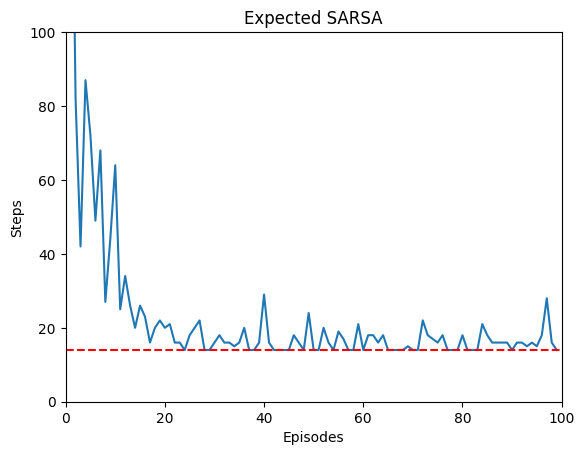

In [15]:
### TODO: try your expected SARSA implementation

# avg_expected_sarsa = 0
# for _ in range(100):
#   Q_e, avg_es, lastSteps = expected_sarsa(world, SARSA_policy, (0,0), 100)
#   avg_expected_sarsa += sum(avg_es)/100

# print(avg_expected_sarsa/100)

Q_e, avg_es, lastSteps = expected_sarsa(world, SARSA_policy, (0,0), 100)

highest_action = np.full((world.width, world.height), '     ')
for x in range(world.width):
    for y in range(world.height):
        highest_action[x, y] = ACTIONS[np.argmax(Q_e[x, y])]
highest_action[7, 7] = 'GOAL'
print("Expected SARSA")
print(lastSteps)
display(pd.DataFrame(highest_action.T))



plt.plot(avg_es)
plt.axhline(y=14, color='r', linestyle='--')
plt.axis([0,100,0,100])
plt.xlabel("Episodes")
plt.ylabel("Steps")
plt.title("Expected SARSA")
plt.show()

Running instance 1/100...
Running instance 2/100...
Running instance 3/100...
Running instance 4/100...
Running instance 5/100...
Running instance 6/100...
Running instance 7/100...
Running instance 8/100...
Running instance 9/100...
Running instance 10/100...
Running instance 11/100...
Running instance 12/100...
Running instance 13/100...
Running instance 14/100...
Running instance 15/100...
Running instance 16/100...
Running instance 17/100...
Running instance 18/100...
Running instance 19/100...
Running instance 20/100...
Running instance 21/100...
Running instance 22/100...
Running instance 23/100...
Running instance 24/100...
Running instance 25/100...
Running instance 26/100...
Running instance 27/100...
Running instance 28/100...
Running instance 29/100...
Running instance 30/100...
Running instance 31/100...
Running instance 32/100...
Running instance 33/100...
Running instance 34/100...
Running instance 35/100...
Running instance 36/100...
Running instance 37/100...
Running in

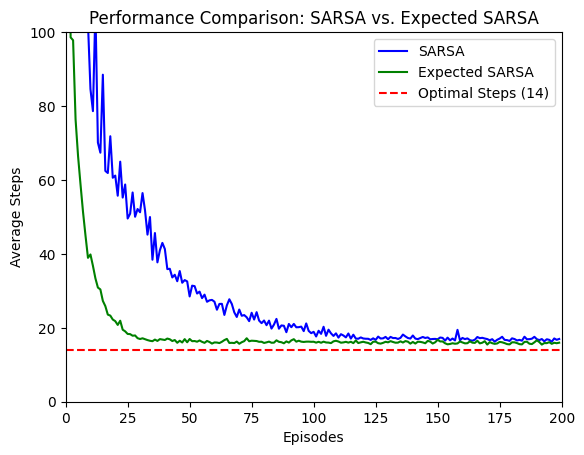

In [46]:

INSTANCES = 100  # Antal instances
EPISODES = 200   # Antal episoder
alpha = 0.1
gamma = 0.9
epsilon = 0.1

# Arrays til at akkumulere antal skridt for SARSA og Expected SARSA
steps_sarsa_all_instances = np.zeros(EPISODES)
steps_expected_sarsa_all_instances = np.zeros(EPISODES)

# Loop over 100 instances
for instance in range(INSTANCES):
    print(f"Running instance {instance + 1}/{INSTANCES}...")
    
    # Kør SARSA
    Q_s, avg_steps_sarsa, _ = sarsa(world, (0, 0), EPISODES, alpha)
    steps_sarsa_all_instances += np.array(avg_steps_sarsa)
    
    # Kør Expected SARSA
    Q_e, avg_steps_expected_sarsa, _ = expected_sarsa(world, SARSA_policy, (0, 0), EPISODES)
    steps_expected_sarsa_all_instances += np.array(avg_steps_expected_sarsa)

# Beregn gennemsnitligt antal skridt for SARSA og Expected SARSA
avg_steps_sarsa = steps_sarsa_all_instances / INSTANCES
avg_steps_expected_sarsa = steps_expected_sarsa_all_instances / INSTANCES

# Plot begge kurver
plt.plot(avg_steps_sarsa, label="SARSA", color="blue")
plt.plot(avg_steps_expected_sarsa, label="Expected SARSA", color="green")
plt.axhline(y=14, color='red', linestyle='--', label="Optimal Steps (14)")
plt.axis([0, EPISODES, 0, 100])
plt.xlabel("Episodes")
plt.ylabel("Average Steps")
plt.title("Performance Comparison: SARSA vs. Expected SARSA")
plt.legend()
plt.show()

### Test and compare your expected SARSA implementation

Test your implementation on the simple $8 \times 8$ world defined above with, ```rand_move_probability = 0.0```, $\epsilon = 0.1$, and $\gamma = 0.9$. Compare the performance of expected SARSA with normal SARSA. How long does it take for the respective methods to solve the tasks optimally (that is, number of steps that an agent takes from start to finish = _width_ + _height_ $-2 = 14$).

Remember that for expected SARSA, you can use a learning rate of 1 ($\alpha = 1)$, whereas for SARSA, you should try different learning rates.


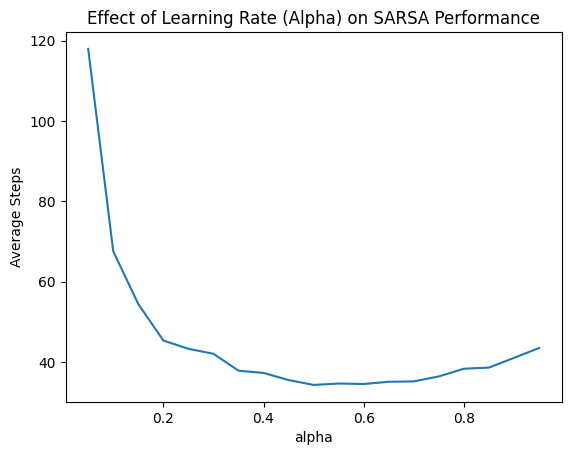

Average steps for alpha = 0.1: 67.53


In [37]:
rand_move_probability = 0.0
epsilon = 0.1
gamma = 0.9

### TODO: Compare the performance of SARSA (different alphas) and
###       expected SARSA (alpha = 1). You need to run multiple
###       experiments (e.g. 100 per setting) and then take the average
###       to get a proper estimate of the general performance.


# highest_action = np.full((world.width, world.height), '     ')
# for x in range(world.width):
#     for y in range(world.height):
#         highest_action[x, y] = ACTIONS[np.argmax(Q_s[x, y])]
# highest_action[7, 7] = 'GOAL'
# print(pd.DataFrame(highest_action.T))



# avg_steps_sarsa = 0
# for _ in range(100):
#   Q_s, steps_list_sarsa, lastSteps = sarsa(world, (0,0), 100, alpha)
#   avg_steps_sarsa += sum(steps_list_sarsa)/100

# print(avg_steps_sarsa/100)

alphaList = []  # Liste til gennemsnitlige antal skridt for hver alpha
INSTANCES = 100  # Antal instanser
EPISODES = 100   # Antal episoder
alpha_values = np.arange(0.05, 1.0, 0.05)  # Alpha-værdier

# Loop over alpha-værdier
for alpha in alpha_values:
    total_steps = np.zeros(EPISODES)  # Akkumulerede steps for alle instances

    # Gentag SARSA 100 gange for hver alpha-værdi
    for _ in range(INSTANCES):
        Q_s, steps_list_sarsa, lastSteps = sarsa(world, (0, 0), EPISODES, alpha)
        total_steps += np.array(steps_list_sarsa)  # Akkumuler steps

    # Beregn gennemsnitligt antal skridt for hver episode
    avg_steps = total_steps / INSTANCES

    # Beregn gennemsnitligt antal skridt over alle episoder og gem i alphaList
    alphaList.append(np.mean(avg_steps))

# Plot resultater
plt.plot(alpha_values, alphaList)

plt.xlabel("alpha")
plt.ylabel("Average Steps")
plt.title("Effect of Learning Rate (Alpha) on SARSA Performance")
plt.show()

# Find og print værdien for alpha = 0.1
alpha_index = list(alpha_values).index(0.1)
print(f"Average steps for alpha = 0.1: {alphaList[alpha_index]:.2f}")



# alpha = 0.2
# pol_s = np.full((world.width, world.height),"     ")
# for x in range(world.width):
#   for y in range(world.height):
#     for action in ACTIONS:
#       pol_s[x,y] = ACTIONS[np.argmax(Q_s[x,y])]
# pol_s[7, 7] = 'GOAL'




# print(f"SARSA, Alpha:{alpha}")
# print(lastSteps)
# display(pd.DataFrame(pol_s.T))


# plt.plot(steps_list_sarsa)
# plt.axis([0,100,0,100])
# plt.xlabel("Episodes")
# plt.ylabel("Steps")
# plt.title("SARSA")
# plt.axhline(y=14, color='r', linestyle='--')
# plt.show()

## Exercise: $n$-step on-policy SARSA or $n$-step on-policy expected SARSA

Here, you should implement on-policy $n$-step bootstrapping. You can either implement $n$-step SARSA or $n$-step expected SARSA. See Chapter 7 in [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html) and page 147 for $n$-step SARSA.

Test you implementation with different values of $n$ either on the $8\times8$ world above or on the ```WindyGridWorld``` from previous lectures. It is up to you to decide how to measure performance: it could, for instance, be the average episode length after a limited number of episodes (for instance $10$), how long it takes to solve the task optimally, like in the exercise on expected SARSA above, or something else.

For the world that you choose, you have to answer the question: "What is a good value for $n$?"

In [17]:
### TODO: Implment and test n-step SARSA or n-step expected SARSA.
Q = np.random.rand(world.width, world.height,len(ACTIONS))

EPISODES = 1000
epsilon = 0.1
alpha = 0.05
gamma = 0.9


def n_step_sarsa(world, start_state, policy, n):
  for episode in range(EPISODES):
    st = []
    act = []
    reward = [0]
    current_state = start_state
    possible_actions = policy(current_state, Q)
    current_action = random.choices(population=list(possible_actions.keys()), weights=possible_actions.values(), k=1)

    act.append(*current_action)
    st.append(current_state)


    action_to_index = {action: i for i, action in enumerate(ACTIONS)}

    T = np.inf
    t = 0
    tau = t-n+1
    while tau != T-1:
      if t<T:
        next_state = world.get_next_state(current_state, *current_action)
        reward.append(world.get_reward(*next_state))
        st.append(next_state)
        current_state = next_state

        if world.is_terminal(*next_state):
          T = t+1
        else:
          possible_actions = policy(next_state, Q)
          next_action = random.choices(population=list(possible_actions.keys()), weights=possible_actions.values(), k=1)
          act.append(*next_action)
          current_action = next_action


      tau = t-n+1
      if tau >= 0:
        G = 0
        for i in range(tau+1, min(tau+n, T)+1):
          G += gamma**(i-tau-1) * reward[i]

        if tau+n < T:
          G += gamma**n * Q[st[tau+n][0], st[tau+n][1], action_to_index[act[tau+n]]]

        Q[st[tau][0], st[tau][1], action_to_index[act[tau]]] += alpha * (G - Q[st[tau][0],st[tau][1], action_to_index[act[tau]]])
      t += 1


world2 = World(8, 8)
world2.add_terminal(7, 7, "+")


n_step_sarsa(world2, (0,0), SARSA_policy, 5)


highest_action = np.full((world2.width, world2.height), '     ')
for x in range(world2.width):
    for y in range(world2.height):
        highest_action[x, y] = ACTIONS[np.argmax(Q[x, y])]
highest_action[7, 7] = 'GOAL'
display(pd.DataFrame(highest_action.T))

,0,1,2,3,4,5,6,7
0,down,left,down,right,down,left,down,down
1,down,up,left,left,left,left,left,right
2,down,left,up,up,left,right,right,down
3,down,up,down,down,left,left,up,down
4,down,right,right,down,right,right,down,right
5,right,right,right,right,right,right,down,down
6,up,left,up,down,left,left,down,down
7,down,down,up,right,right,right,right,GOAL
